In [90]:
import os.path as osp
from dataclasses import dataclass
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

#printing
from torch_geometric import utils
import networkx as nx

from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

/var/folders/3t/9jk6b03d78zf_3slsmhznk0c0000gn/T/ipykernel_89136/2841115691.py:70: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  y=torch.tensor(edge_labels, dtype=torch.bool)


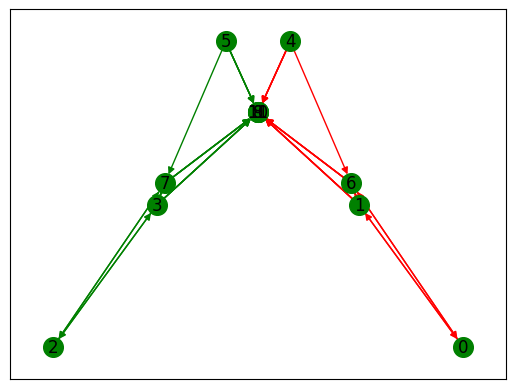

In [206]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import os
from typing import Dict, Tuple
import pandas as pd

Edges = Dict[Tuple[int, int], Tuple[int, ...]]
Nodes = Dict[int, Tuple[int, ...]]

all_edges: Dict[Tuple[int, int], Tuple[int, ...]] = {}

graph_data_directory = 'graph_data'
case_dirs = []
for file in os.listdir(graph_data_directory):
    new_dir = os.path.join(graph_data_directory, file)
    case_dirs.append(new_dir)

case_dirs = sorted(case_dirs)


cgs = [os.path.join(fpath, 'cg.csv') for fpath in case_dirs]
nodes = [os.path.join(fpath, 'nodes.csv') for fpath in case_dirs]

class OurData():
    edge_batches: Tuple[Edges] = ()
    node_batches: Tuple[Nodes] = ()


    def register_batch(self, edges: Edges, nodes: Nodes):
        self.edge_batches += (edges,)
        self.node_batches += (nodes,)

    def __repr__(self):
        return f'OurData(edge_batches={self.edge_batches}, node_batches={self.node_batches})'

    def __str__(self):
        return self.__repr__()
our_data = OurData()

for cg, node in zip(cgs, nodes):
    cg_df = pd.read_csv(cg, index_col=[0,1])
    cg_df.sort_index(inplace=True)
    # print(cg_df)
    # 3/0
    node_df = pd.read_csv(node, index_col=0)
    edges = cg_df.index
    edge_features = cg_df[['type_pre_eff', 'type_eff_eff']].values
    edge_labels = cg_df['label'].values
    edge_dict = {}
    for edge, edge_feature, label in zip(edges, edge_features, edge_labels):
        edge_dict[tuple(edge)] = (edge_feature, label)


    our_data.register_batch(edge_dict, node_df)


data_batches = []

for edge_batch, node_batch in zip(our_data.edge_batches, our_data.node_batches):

    edges = edge_batch
    nodes = node_batch
    edge_features, edge_labels = zip(*[edges[edge] for edge in sorted(edges.keys())])
    

    data = Data(
        x=torch.tensor(nodes.values, dtype=torch.float),
        edge_index=torch.tensor(list(sorted(edges.keys())), dtype=torch.long).t().contiguous(),
        edge_attr=torch.tensor(edge_features, dtype=torch.float),
        y=torch.tensor(edge_labels, dtype=torch.bool)
    )
    data_batches.append(data)

data_loader = DataLoader(data_batches, batch_size=2, shuffle=True)

this_data = data_loader.dataset[1]

g = utils.to_networkx(this_data)


color = ['green' if this_data.y[i] else 'red' for i in range(this_data.y.size(0))]
import matplotlib as plt
a = nx.draw_networkx(g,node_size=200, pos=nx.spectral_layout(g), edge_color=color, node_color='green', with_labels=True)

# edge_color=this_data.y
# edge_color

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

class MyData(Data):
    my_id = 0
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.my_id = MyData.my_id
        MyData.my_id += 1
    def __cat_dim__(self, key, value, *args, **kwargs):
         if key == 'foo':
             return None
         else:
             return super().__cat_dim__(key, value, *args, **kwargs)

edge_index = torch.tensor([
   [0, 1, 1, 2],
   [1, 0, 2, 1],
])



foo = torch.randn(16)

data = MyData(edge_index=edge_index, foo=foo)
data1 = MyData(edge_index=edge_index, foo=foo)
data2 = MyData(edge_index=edge_index, foo=foo)
data_list = [data, data1, data2]
loader = DataLoader(data_list, batch_size=2, shuffle=True)
batch = next(iter(loader))

print(batch[0].my_id)
print(batch[1].my_id)





In [208]:
OneBatch = Data
class Net(torch.nn.Module):
    def __init__(self, features_num):
        super(Net, self).__init__()
        self.conv1 = GCNConv(features_num, 128)
        self.conv2 = GCNConv(128, 64)

    def encode(self, data):
        x = self.conv1(data.x, data.edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, data.edge_index) # convolution 2



    def decode(self, z, edge_index): # only pos and neg edges
        # if not test:
        #     print('pos_edge_index', pos_edge_index.shape)
        #     print('neg_edge_index', neg_edge_index.shape)
            # print('pos_edge_index', pos_edge_index)
            # print('neg_edge_index', neg_edge_index)

        # if not test:
        #     print('edge_index 0 shape:', edge_index[0].shape)
        #     # print("Edge index 0: ", edge_index[0])
        #TODO  edge_index[0] 7 4 9

        #     print("Edge index 1 shape: ", edge_index[1].shape)
        #     # print("Edge index 1: ", edge_index[1])
        #TODO edge_index[1] 5 3 9
        #     print("z shape: ", z.shape)

        # Multiply adjecency matrix with latent space using the COO format of 
        # Edge index[0] and Edge index[1]
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        # if not test:
        #     print('logits shape:', logits.shape)
        #     print('logits', logits)
        #     4/0

        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

In [232]:
num_node_features = next(iter(data_loader)).x.shape[1]
model, data = Net(num_node_features).to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
batch = next(iter(data_loader))
print(batch[0].x.shape)
print(batch[1].x.shape)


torch.Size([12, 2])
torch.Size([13, 2])


In [257]:
def train():
    model.train()  # Flag to modify the gradient

    batch = next(iter(data_loader))  # This is next level shit
    # print(batch[0])
    # print(batch[1])
    edge_index = batch.edge_index
    optimizer.zero_grad()
    z = model.encode(batch) 
    link_logits = model.decode(z, edge_index) # decode
    # print(link_logits)
    link_labels = batch.y
    # print(link_labels)
    link_labels = link_labels.type(torch.float)
    # print(link_labels)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index, test=True) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        
        link_labels = get_link_labels(neg_edge_index, pos_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs

In [258]:
best_val_perf = test_perf = 0
for epoch in range(1, 101):
    train_loss = train()
    # val_perf, tmp_test_perf = test()
    # if val_perf > best_val_perf:
    #     best_val_perf = val_perf
    #     test_perf = tmp_test_perf
    # log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    log = 'Epoch: {:03d}, Loss: {:.4f}'
    if epoch % 10 == 0:
    #     print(log.format(epoch, train_loss, best_val_perf, test_perf))
        print(log.format(epoch, train_loss))

Epoch: 010, Loss: 1.4836
Epoch: 020, Loss: 0.0211
Epoch: 030, Loss: 0.4479
Epoch: 040, Loss: 0.4292
Epoch: 050, Loss: 0.3755
Epoch: 060, Loss: 0.3718
Epoch: 070, Loss: 0.2479
Epoch: 080, Loss: 0.3556
Epoch: 090, Loss: 0.0783
Epoch: 100, Loss: 0.2439


In [175]:
t1 = 10*torch.rand((2,5))
t2 = 10*torch.rand((2,5))
t1 = t1.round()
t2 = -t2.round()
a = torch.cat([t1,t2], dim=-1)
a.shape

t1[1]

tensor([ 9.,  8.,  4.,  5., 10.])

In [143]:
nodes = torch.rand(2704, 64)
n1 = nodes[[12,13,14]]
n2 = nodes[[15,16,17]]
ressss = n1*n2
ressss.sum(-1)

tensor([17.6733, 15.0368, 14.3092])